In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import pandas as pd
import seaborn as sns
import numpy as np
import os
from os.path import join
from statsmodels.tsa.tsatools import detrend
import statsmodels.formula.api as sm
import itertools
import sys
import datetime
# sns.set()
idx = pd.IndexSlice

In [2]:
# Load the "autoreload" extension
%load_ext autoreload

# always reload modules marked with "%aimport"
%autoreload 1

In [3]:
# add the 'src' directory as one where we can import modules
src_dir = join(os.getcwd(), os.pardir, 'src')
sys.path.append(src_dir)

In [4]:
%aimport Analysis.index
from Analysis.index import facility_co2, adjust_epa_emissions, group_fuel_cats
from Analysis.index import reduce_emission_factors, add_datetime
%aimport util.utils
from util.utils import rename_cols

## Load national index and percent gen data

In [5]:
cwd = os.getcwd()
path = join(cwd, '..', 'Data storage', 'National data', 'National index.csv')
national_index = pd.read_csv(path, parse_dates=['datetime'])
national_index['nerc'] = 'USA'
rename_cols(national_index)

In [6]:
national_index.head()

,year,month,generation (mwh),final co2 (kg),datetime,quarter,index (g/kwh),change since 2005,index (lb/mwh),nerc
0,2001,1,332493160.0,2.149920e+11,2001-01-01,1,646.604591,0.076326,1425.504481,USA
1,2001,2,282940198.0,1.803140e+11,2001-02-01,1,637.284923,0.060812,1404.958340,USA
2,2001,3,300706544.0,1.891340e+11,2001-03-01,1,628.965732,0.046964,1386.617853,USA
3,2001,4,278078871.0,1.748850e+11,2001-04-01,2,628.902838,0.046860,1386.479197,USA
4,2001,5,300491621.0,1.892470e+11,2001-05-01,2,629.790069,0.048337,1388.435187,USA


In [7]:
path = join(cwd, '..', 'Data storage', 'National data', 'National percent gen.csv')
national_per_gen = pd.read_csv(path)
add_datetime(national_per_gen)
national_per_gen['nerc'] = 'USA'

In [8]:
national_per_gen.head()

,year,month,fuel category,generation (mwh),datetime,nerc
0,2001,1,Coal,0.533205,2001-01-01,USA
1,2001,2,Coal,0.529212,2001-02-01,USA
2,2001,3,Coal,0.516347,2001-03-01,USA
3,2001,4,Coal,0.505866,2001-04-01,USA
4,2001,5,Coal,0.504483,2001-05-01,USA


In [9]:
path = join(cwd, '..', 'Data storage', 'National data', 'National generation.csv')
national_gen = pd.read_csv(path)
add_datetime(national_gen)
national_gen['nerc'] = 'USA'

In [10]:
national_gen.head()

,fuel category,year,month,generation (mwh),datetime,nerc
0,Coal,2001,1,177287111.0,2001-01-01,USA
1,Coal,2001,2,149735484.0,2001-02-01,USA
2,Coal,2001,3,155269011.0,2001-03-01,USA
3,Coal,2001,4,140670654.0,2001-04-01,USA
4,Coal,2001,5,151592914.0,2001-05-01,USA


## Load NERC index and percent gen data

In [11]:
path = join(cwd, '..', 'Data storage', 'final NERC data', 'NERC gen emissions and index.csv')
nerc_index = pd.read_csv(path, parse_dates=['datetime'])
nerc_index.rename(columns={'index': 'index (g/kwh)'}, inplace=True)

In [12]:
nerc_index.head()

,nerc,year,month,final co2 (kg),generation (mwh),index (g/kwh),datetime
0,-,2001,1,5.476076e+09,7185661.388,762.083771,2001-01-01
1,-,2001,2,4.349473e+09,6526739.453,666.408193,2001-02-01
2,-,2001,3,4.223575e+09,6304139.884,669.968545,2001-03-01
3,-,2001,4,4.544873e+09,6624660.323,686.053817,2001-04-01
4,-,2001,5,4.972656e+09,7045482.729,705.793523,2001-05-01


In [13]:
path = join(cwd, '..', 'Data storage', 'final NERC data', 'NERC percent gen.csv')
nerc_per_gen = pd.read_csv(path, parse_dates=['datetime'])
nerc_per_gen.drop(['year', 'month'], inplace=True, axis=1)

In [14]:
nerc_per_gen.head()

,fuel category,datetime,nerc,generation (mwh)
0,Coal,2001-01-01,-,0.693624
1,Coal,2001-02-01,-,0.616249
2,Coal,2001-03-01,-,0.601500
3,Coal,2001-04-01,-,0.621707
4,Coal,2001-05-01,-,0.637201


## Combine NERC and national results

In [15]:
index = pd.concat([national_index, nerc_index])

In [16]:
index.head()

,change since 2005,datetime,final co2 (kg),generation (mwh),index (g/kwh),index (lb/mwh),month,nerc,quarter,year
0,0.076326,2001-01-01,2.149920e+11,332493160.0,646.604591,1425.504481,1,USA,1.0,2001
1,0.060812,2001-02-01,1.803140e+11,282940198.0,637.284923,1404.958340,2,USA,1.0,2001
2,0.046964,2001-03-01,1.891340e+11,300706544.0,628.965732,1386.617853,3,USA,1.0,2001
3,0.046860,2001-04-01,1.748850e+11,278078871.0,628.902838,1386.479197,4,USA,2.0,2001
4,0.048337,2001-05-01,1.892470e+11,300491621.0,629.790069,1388.435187,5,USA,2.0,2001


In [17]:
per_gen = pd.concat([national_per_gen, nerc_per_gen])
per_gen.rename(columns={'generation (mwh)': 'Fraction Generation'}, inplace=True)
per_gen.year = per_gen['datetime'].dt.year
per_gen.month = per_gen['datetime'].dt.month

In [18]:
per_gen.head()

,datetime,fuel category,Fraction Generation,month,nerc,year
0,2001-01-01,Coal,0.533205,1,USA,2001
1,2001-02-01,Coal,0.529212,2,USA,2001
2,2001-03-01,Coal,0.516347,3,USA,2001
3,2001-04-01,Coal,0.505866,4,USA,2001
4,2001-05-01,Coal,0.504483,5,USA,2001


## Figures

In [19]:
sns.set_style('white', {'axes.linewidth': 1.5,
                        'axes.grid': True})
sns.set_context('notebook', font_scale=1.2)

In [20]:
def region_facet_grid(df, plot_function, x_axis, y_axis, col_order=None,
                      suptitle='', add_legend=False, ax_labels=None,
                      FG_kwargs={}, plot_kwargs={}, context='notebook',
                      font_scale=1.2):
    sns.set_context(context, font_scale)
    g = sns.FacetGrid(df, col_order=col_order, **FG_kwargs)
    g.map(plot_function, x_axis, y_axis, **plot_kwargs)
    g.set_xticklabels(rotation=35)
    if add_legend:
        g.add_legend()
    if suptitle:
        plt.suptitle(suptitle, y=1.02, size=15)
    if col_order and 'col' in FG_kwargs:
        axes = g.axes.flatten()
        for ax, title in zip(axes, order):
            ax.set_title(title)
    if ax_labels:
        g.set_axis_labels(ax_labels)

### Index figure

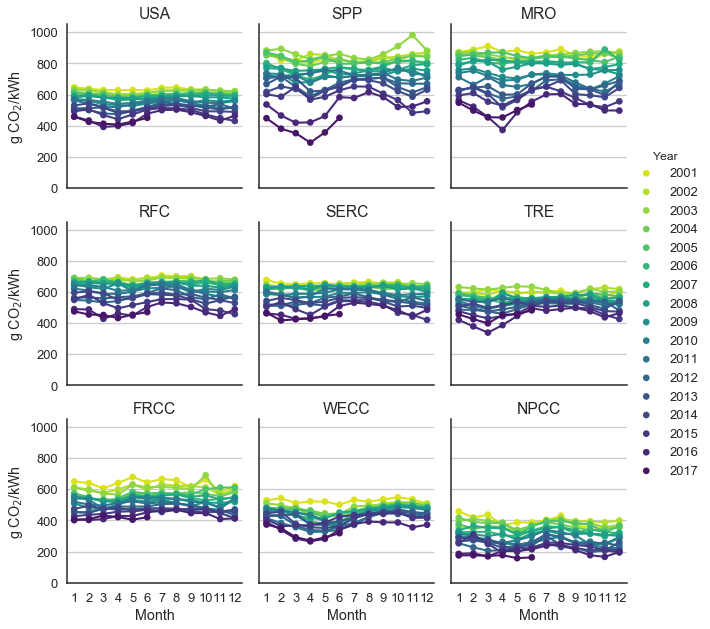

In [276]:
order = ['USA', 'SPP', 'MRO', 'RFC', 'SERC', 'TRE', 'FRCC', 'WECC', 'NPCC']
temp = index.copy()
temp.rename(columns={'month': 'Month',
                     'year': 'Year'}, inplace=True)
with sns.plotting_context('talk', font_scale=1):

    g = sns.factorplot(x='Month', y='index (g/kwh)', hue='Year', 
                       data=temp, col='nerc', col_wrap=3, col_order=order, 
                       palette='viridis_r', scale=0.5, size=3)

    axes = g.axes.flatten()
    for ax, title in zip(axes, order):
        ax.set_title(title)
        ax.set_ylim(0, 1050)
        if title in ['USA', 'RFC', 'FRCC']:
            ax.set_ylabel('g CO$_2$/kWh')
            
path = join(cwd, '..', 'Figures', 'Monthly index (12-months)_full.pdf')
# plt.savefig(path, bbox_inches='tight')

### Percent gen figures

#### Color palette for fuel categories

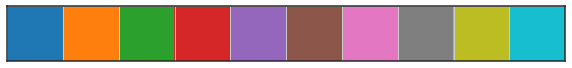

In [21]:
sns.palplot(sns.color_palette('tab10', n_colors=10))

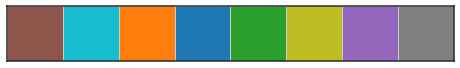

In [22]:
fuel_order = [5, -1, 1, 0, 2, -2, 4, -3]
fuel_palette = [sns.color_palette('tab10', n_colors=10)[x]
                for x in fuel_order]
sns.palplot(fuel_palette)

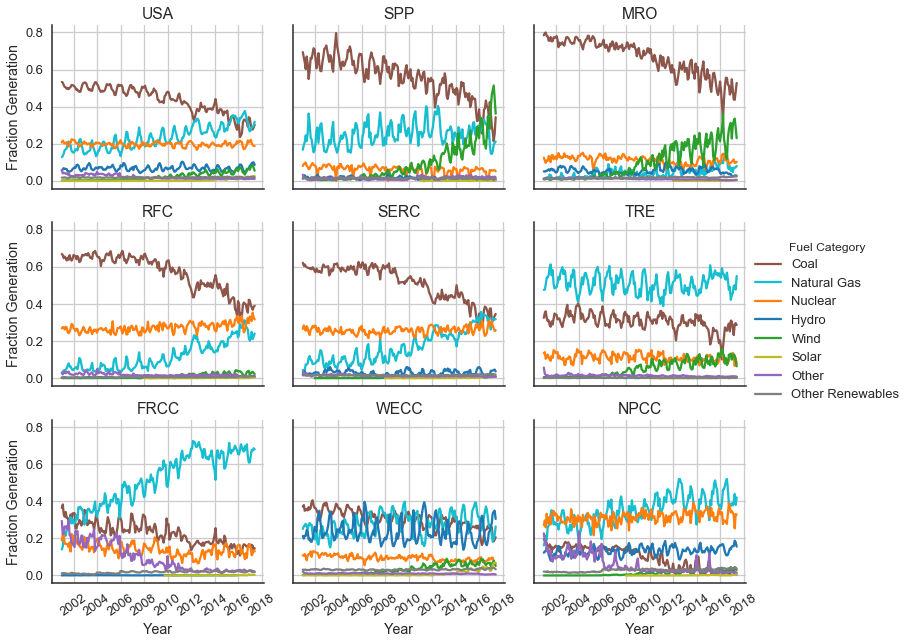

In [48]:
order = ['USA', 'SPP', 'MRO', 'RFC', 'SERC', 'TRE', 'FRCC', 'WECC', 'NPCC']
fuel_order = ['Coal', 'Natural Gas', 'Nuclear', 'Hydro', 'Wind', 'Solar',
              'Other', 'Other Renewables']
temp = per_gen.copy()
temp.rename(columns={'fuel category': 'Fuel Category'}, inplace=True)

FG_kwargs = dict(hue='Fuel Category',
                 col='nerc',
                 col_wrap=3,
                 aspect=1.2,
                 hue_order=fuel_order,
                 palette=fuel_palette)

region_facet_grid(df=temp, plot_function=plt.plot, x_axis='datetime',
                  add_legend=True, y_axis='Fraction Generation', col_order=order, 
                  suptitle='', FG_kwargs=FG_kwargs, ax_labels='Year',
                  context='talk', font_scale=1)

path = join(cwd, '..', 'Figures', 'Generation by fuel_full.pdf')
plt.savefig(path, bbox_inches='tight')

## Figure of wind, nat gas, and coal

In [21]:
per_gen.dtypes

datetime               datetime64[ns]
fuel category                  object
Fraction Generation           float64
month                           int64
nerc                           object
year                            int64
dtype: object

In [82]:
per_gen.loc[(per_gen['fuel category'].isin(['Wind', 'Coal', 'Natural Gas'])) & 
                             (per_gen.nerc.isin(order)) &
                             (per_gen.year >= 2005)].head()

,datetime,fuel category,Fraction Generation,month,nerc,year
2612,2005-01-01,Coal,0.753739,NaN,MRO,2005
2613,2005-02-01,Coal,0.766800,NaN,MRO,2005
2614,2005-03-01,Coal,0.780396,NaN,MRO,2005
2615,2005-04-01,Coal,0.774250,NaN,MRO,2005
2616,2005-05-01,Coal,0.762964,NaN,MRO,2005


In [22]:
order = ['SPP', 'TRE', 'MRO']
fuels = ['Coal', 'Natural Gas', 'Nuclear', 'Hydro', 'Wind', 'Solar']
per_gen.year = per_gen.year.astype(int)
temp_df = per_gen.loc[(per_gen['fuel category'].isin(['Wind', 'Coal', 'Natural Gas'])) & 
                             (per_gen.nerc.isin(order)) &
                             (per_gen.year >= 2005)].copy()

def early_late(x):
    if x <= 2008:
        return '2005-2008'
    elif x <= 2012:
        return '2009-2012'
    elif x <= 2016:
        return '2013-2016'
    else:
        return ValueError

temp_df.loc[:, 'timeframe'] = temp_df.loc[:, 'year'].map(early_late)
merge_cols = ['nerc', 'month', 'year']
temp_df = pd.merge(temp_df, index[merge_cols + ['generation (mwh)']],
                   on=merge_cols)
temp_df['generation'] = (temp_df.loc[:, 'Fraction Generation']
                         * temp_df.loc[:, 'generation (mwh)'] / 1e6)

In [23]:
temp_df.head()

,datetime,fuel category,Fraction Generation,month,nerc,year,timeframe,generation (mwh),generation
0,2005-01-01,Coal,0.753739,1,MRO,2005,2005-2008,1.552018e+07,11.698157
1,2005-01-01,Natural Gas,0.025970,1,MRO,2005,2005-2008,1.552018e+07,0.403064
2,2005-01-01,Wind,0.014663,1,MRO,2005,2005-2008,1.552018e+07,0.227579
3,2005-02-01,Coal,0.766800,2,MRO,2005,2005-2008,1.338076e+07,10.260365
4,2005-02-01,Natural Gas,0.024931,2,MRO,2005,2005-2008,1.338076e+07,0.333600


In [26]:
# a is the list of colors
a = fuel_palette[0:2]
a.append(fuel_palette[4])

/Users/Home/anaconda/envs/py36/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


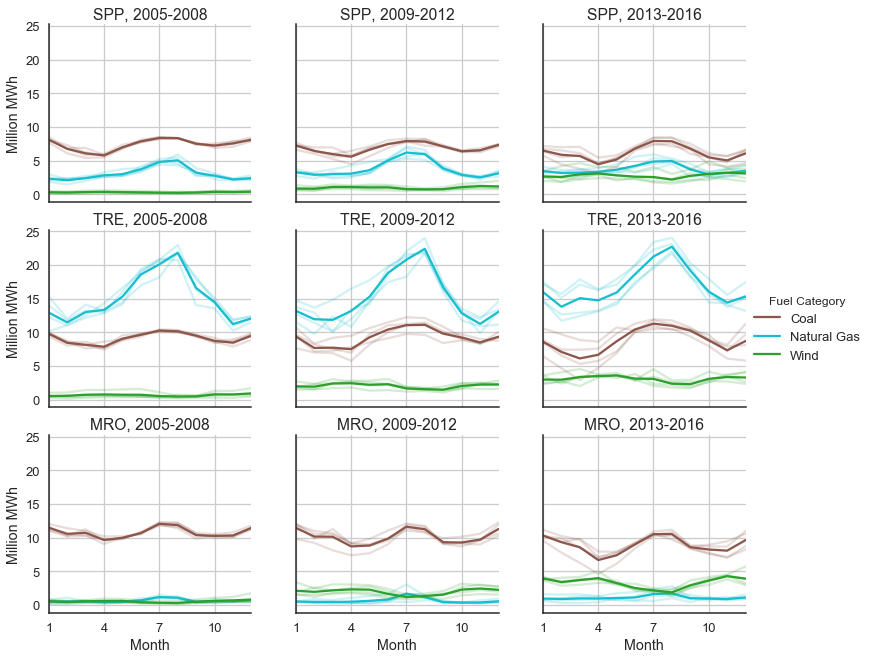

In [328]:
order = ['SPP', 'TRE', 'MRO']
col_order = ['2005-2008', '2009-2012', '2013-2016']

with sns.plotting_context(font_scale=1.2):
    g = sns.FacetGrid(temp_df, col='timeframe', row='nerc',
                      col_order=col_order, row_order=order, aspect=1.15)
    g.map_dataframe(sns.tsplot, time='month', unit='year', value='generation', 
                    condition='fuel category', err_style='unit_traces',
                    color=a).add_legend(title='Fuel Category')
    g.set_axis_labels('Month', 'Million MWh')
    titles = ['{}, {}'.format(a, b) for (a, b) in 
              list(itertools.product(order, col_order))]
    axes = g.axes.flatten()
    for ax, title in zip(axes, titles):
        ax.set_title(title)
        ax.set_xticks([1, 4, 7, 10])

path = join(cwd, '..', 'Figures', 'Wind-Coal-NG variability tsplot.pdf')
plt.savefig(path, bbox_inches='tight')

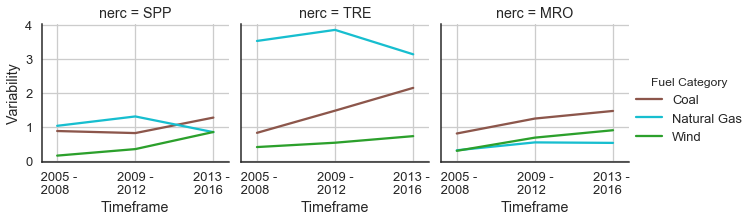

In [325]:
map_timeframe = {'2005-2008': 0,
                 '2009-2012': 0.5,
                 '2013-2016': 1}

data = (temp_df.groupby(['nerc', 'fuel category', 'timeframe'])
                   .std()
                   .reset_index())
data['frame'] = data['timeframe'].map(map_timeframe)
data.sort_values(['nerc', 'fuel category', 'frame'], inplace=True)

g = sns.FacetGrid(data, hue='fuel category', col='nerc',
                  col_order=['SPP', 'TRE', 'MRO'], palette=a)
g.map(plt.plot, 'frame', 'generation').add_legend(title='Fuel Category')
g.set_axis_labels('Timeframe', 'Variability')
axes = g.axes.flatten()
for ax in axes:
    ax.set_xticks([0, 0.5, 1])
    ax.set_xticklabels([' 2005 -\n 2008  ', '2009 -\n2012  ',
                        '2013 - \n2016   '])
    ax.set_xlim(-.1, 1.1)


path = join(cwd, '..', 'Figures', 'SI', 'Wind-Coal-NG variability.pdf')
plt.savefig(path, bbox_inches='tight')

## Correlation figures
Creating a wide dataframe and then melting it to a tidy one is extra work. Might want to come back and create a tidy df from the start.

In [101]:
# Pairs of adjacent NERC regions
region_pairs = [
#     ('WECC', 'MRO'),
    ('WECC', 'SPP'),
    ('WECC', 'TRE'),
    ('TRE', 'SPP'),
    ('TRE', 'SERC'),
    ('SPP', 'MRO'),
    ('SPP', 'SERC'),
    ('SERC', 'FRCC'),
    ('SERC', 'MRO'),
    ('RFC', 'SERC'),
    ('RFC', 'NPCC'),
    ('MRO', 'NPCC'),
    ('MRO', 'WECC')
]

In [48]:
index.reset_index(inplace=True)
index.set_index(['nerc', 'datetime'], inplace=True)
index.sort_index(inplace=True)

In [49]:
index.head()

index  change since 2005  final co2 (kg)  generation (mwh)  \
nerc datetime                                                                 
-    2001-01-01      0                NaN    5.476076e+09       7185661.388   
     2001-02-01      1                NaN    4.349473e+09       6526739.453   
     2001-03-01      2                NaN    4.223575e+09       6304139.884   
     2001-04-01      3                NaN    4.544873e+09       6624660.323   
     2001-05-01      4                NaN    4.972656e+09       7045482.729   

                 index (g/kwh)  index (lb/mwh)  month  quarter  year  
nerc datetime                                                         
-    2001-01-01     762.083771             NaN      1      NaN  2001  
     2001-02-01     666.408193             NaN      2      NaN  2001  
     2001-03-01     669.968545             NaN      3      NaN  2001  
     2001-04-01     686.053817             NaN      4      NaN  2001  
     2001-05-01     705.793523             NaN      5      NaN  2001

In [135]:
def rolling_corr_plot(index, region_pairs, window, center=True,
                      order=None, legend_order=None,
                      x_lim=(2001, 2017)):
    
    index.reset_index(inplace=True)
    index.set_index(['nerc', 'datetime'], inplace=True)
    index.sort_index(inplace=True)
    
    
    corr_df = pd.concat([(index.loc[regions[0]]['index (g/kwh)']
                         .rolling(window, center=center)
                         .corr(index.loc[regions[1]]['index (g/kwh)']))
                         for regions in region_pairs], axis=1)
    cols = ['{} | {}'.format(regions[0], regions[1]) for regions in region_pairs]
    corr_df.columns = cols
    
    corr_tidy = pd.melt(corr_df.reset_index(), id_vars='datetime',
                        value_name='Correlation')
    corr_tidy['region1'] = corr_tidy['variable'].str.split(' | ').str[0]
    corr_tidy['region2'] = corr_tidy['variable'].str.split(' | ').str[-1]

    #datetime_s is seconds since epoch - regplot won't take datetime objects
    corr_tidy['datetime_s'] = corr_tidy['datetime'].astype(int)
    
    if not order:
        order = ['WECC', 'TRE', 'SPP', 'SERC', 'RFC', 'MRO']
        
    if not legend_order:
        legend_order = ['SPP', 'TRE', 'SERC', 'MRO', 'FRCC', 'NPCC', 'WECC']
    legend_len = len(legend_order)
    
    g = sns.FacetGrid(corr_tidy.dropna(), col='region1', col_wrap=2, aspect=1.25,
                      hue='region2', palette='tab10', size=2.5,
                      hue_order=legend_order)
    g.map(sns.regplot, 'datetime_s', 'Correlation', marker='.',
          truncate=True, scatter_kws={'s': 0})

    # regplot only does a scatter - add plt.plot for the lines
    g.map(plt.plot, 'datetime_s', 'Correlation')


    # Create custom patch lines for the legend - the default dots were small
    plot_colors = sns.color_palette('tab10', legend_len)
    legend_patches = [mlines.Line2D([], [], color=c) for c in plot_colors]
    legend_data = dict(zip(legend_order, legend_patches))
    g.add_legend(legend_data=legend_data, title='Second Region')

    # Need to do all x-axis work in seconds since epoch, since that's what I'm
    # passing through to regplot.
    axes = g.axes.flatten()

    # Grid lines at the start of each odd year from 2001-17
    x_ticks = pd.to_datetime([str(x) for x in 
                              range(x_lim[0], x_lim[1] + 1, 2)]).astype(int)
    for ax, title in zip(axes, order):
        ax.set_title(title)
        ax.set_xticks(x_ticks)

    # Year for the ticklabels
    g.set_xticklabels(pd.to_datetime(x_ticks).year, rotation=35)
    g.set_xlabels('Year')

### Compare different rolling windows (12, 24, 36, 48, and 72 months)

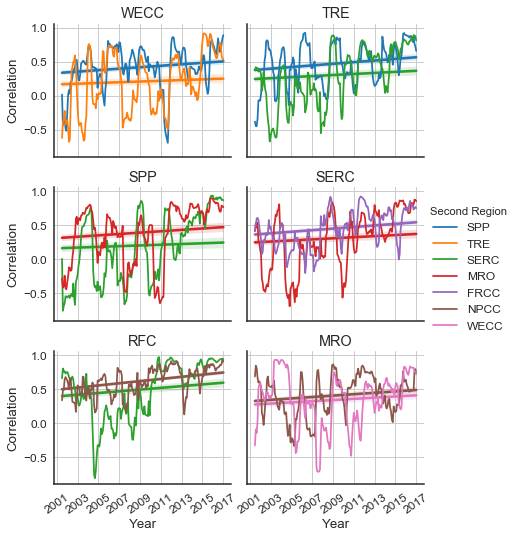

In [124]:
rolling_corr_plot(index, region_pairs=region_pairs, window=12)

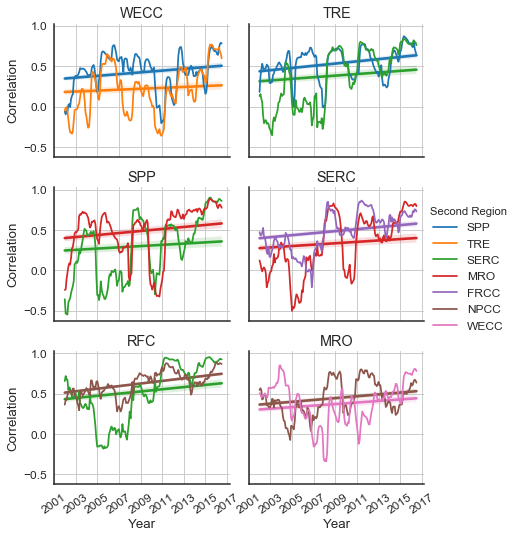

In [125]:
rolling_corr_plot(index, region_pairs=region_pairs, window=24)

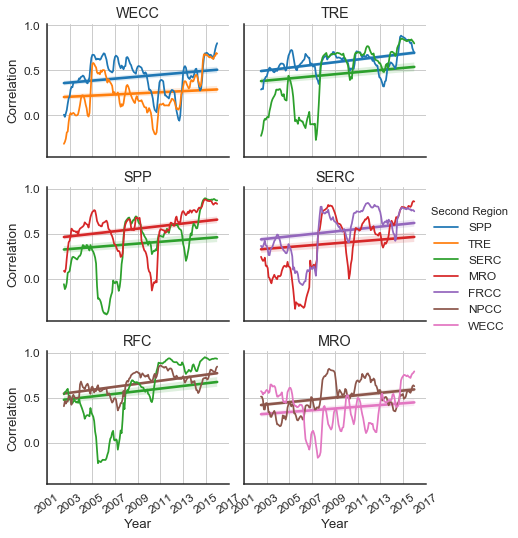

In [126]:
rolling_corr_plot(index, region_pairs=region_pairs, window=36)

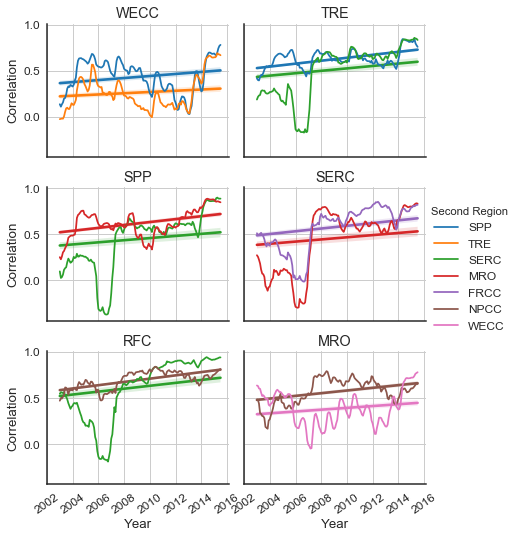

In [137]:
rolling_corr_plot(index, region_pairs=region_pairs, window=48,
                  x_lim=(2002, 2016))
path = join(cwd, '..', 'Figures', 'Rolling correlation - 48m centered.pdf')
plt.savefig(path, bbox_inches='tight')

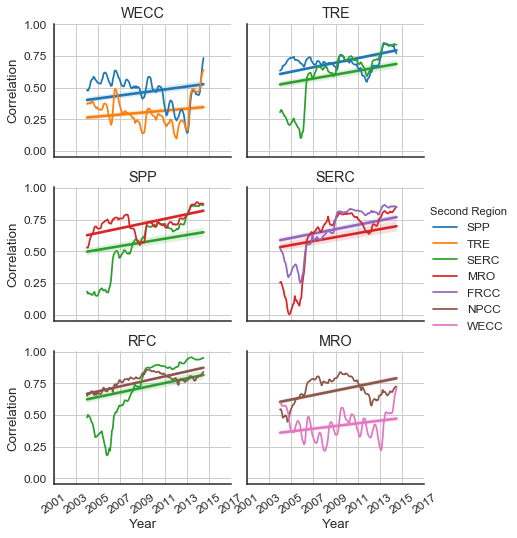

In [132]:
rolling_corr_plot(index, region_pairs=region_pairs, window=72)

In [107]:
corr_df = pd.concat([(index.loc[regions[0]]['index (g/kwh)']
                     .rolling(24, center=True)
                     .corr(index.loc[regions[1]]['index (g/kwh)']))
                     for regions in region_pairs], axis=1)
cols = ['{} | {}'.format(regions[0], regions[1]) for regions in region_pairs]
corr_df.columns = cols

In [108]:
corr_df.tail()

,WECC | SPP,WECC | TRE,TRE | SPP,TRE | SERC,SPP | MRO,SPP | SERC,SERC | FRCC,SERC | MRO,RFC | SERC,RFC | NPCC,MRO | NPCC,MRO | WECC
datetime,,,,,,,,,,,,
2017-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-03-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-05-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-06-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [109]:
corr_tidy = pd.melt(corr_df.reset_index(), id_vars='datetime',
                    value_name='Correlation')
corr_tidy['region1'] = corr_tidy['variable'].str.split(' | ').str[0]
corr_tidy['region2'] = corr_tidy['variable'].str.split(' | ').str[-1]

#datetime_s is seconds since epoch - regplot won't take datetime objects
corr_tidy['datetime_s'] = corr_tidy['datetime'].astype(int)
corr_tidy.tail()

,datetime,variable,Correlation,region1,region2,datetime_s
2371,2017-02-01,MRO | WECC,NaN,MRO,WECC,1485907200000000000
2372,2017-03-01,MRO | WECC,NaN,MRO,WECC,1488326400000000000
2373,2017-04-01,MRO | WECC,NaN,MRO,WECC,1491004800000000000
2374,2017-05-01,MRO | WECC,NaN,MRO,WECC,1493596800000000000
2375,2017-06-01,MRO | WECC,NaN,MRO,WECC,1496275200000000000


In [110]:
corr_tidy.region1.unique(), corr_tidy.region2.unique()

(array(['WECC', 'TRE', 'SPP', 'SERC', 'RFC', 'MRO'], dtype=object),
 array(['SPP', 'TRE', 'SERC', 'MRO', 'FRCC', 'NPCC', 'WECC'], dtype=object))

In [81]:
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

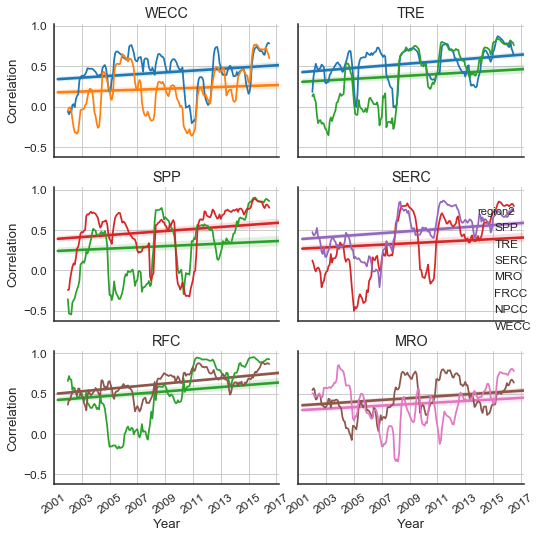

In [113]:
order = ['WECC', 'TRE', 'SPP', 'SERC', 'RFC', 'MRO']
g = sns.FacetGrid(corr_tidy.dropna(), col='region1', col_wrap=2, aspect=1.3,
                  hue='region2', palette='tab10', size=2.5)
g.map(sns.regplot, 'datetime_s', 'Correlation', marker='.',
      scatter_kws={'s': 0}).add_legend()

# regplot only does a scatter - add plt.plot for the lines
g.map(plt.plot, 'datetime_s', 'Correlation')


# Create custom patch lines for the legend - the default dots were small
plot_colors = sns.color_palette('tab10', 7)
legend_patches = [mlines.Line2D([], [], color=c) for c in plot_colors]
legend_order = ['MRO', 'SPP', 'TRE', 'SERC', 'FRCC', 'RFC', 'NPCC']
legend_data = dict(zip(legend_order, legend_patches))
# g.add_legend(legend_data=legend_data, title='Second Region')
# g.add_legend()

# Need to do all x-axis work in seconds since epoch, since that's what I'm
# passing through to regplot.
axes = g.axes.flatten()

# Grid lines at the start of each odd year from 2001-17
x_ticks = pd.to_datetime([str(x) for x in range(2001, 2018, 2)]).astype(int)
for ax, title in zip(axes, order):
    ax.set_title(title)
    ax.set_xticks(x_ticks)

# Year for the ticklabels
g.set_xticklabels(pd.to_datetime(x_ticks).year, rotation=35)
g.set_xlabels('Year')

path = join(cwd, '..', 'Figures', 'Rolling correlation.pdf')
# plt.savefig(path, bbox_inches='tight')

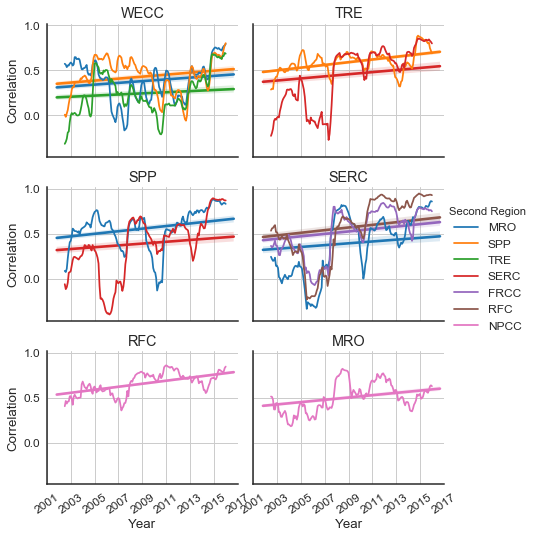

In [67]:
order = ['WECC', 'TRE', 'SPP', 'SERC', 'RFC', 'MRO']
g = sns.FacetGrid(corr_tidy.dropna(), col='region1', col_wrap=2, aspect=1.3,
                  hue='region2', palette='tab10', size=2.5)
g.map(sns.regplot, 'datetime_s', 'Correlation', marker='.',
      scatter_kws={'s': 0})

# regplot only does a scatter - add plt.plot for the lines
g.map(plt.plot, 'datetime_s', 'Correlation')


# Create custom patch lines for the legend - the default dots were small
plot_colors = sns.color_palette('tab10', 7)
legend_patches = [mlines.Line2D([], [], color=c) for c in plot_colors]
legend_order = ['MRO', 'SPP', 'TRE', 'SERC', 'FRCC', 'RFC', 'NPCC']
legend_data = dict(zip(legend_order, legend_patches))
g.add_legend(legend_data=legend_data, title='Second Region')

# Need to do all x-axis work in seconds since epoch, since that's what I'm
# passing through to regplot.
axes = g.axes.flatten()

# Grid lines at the start of each odd year from 2001-17
x_ticks = pd.to_datetime([str(x) for x in range(2001, 2018, 2)]).astype(int)
for ax, title in zip(axes, order):
    ax.set_title(title)
    ax.set_xticks(x_ticks)

# Year for the ticklabels
g.set_xticklabels(pd.to_datetime(x_ticks).year, rotation=35)
g.set_xlabels('Year')

path = join(cwd, '..', 'Figures', 'Rolling correlation.pdf')
# plt.savefig(path, bbox_inches='tight')

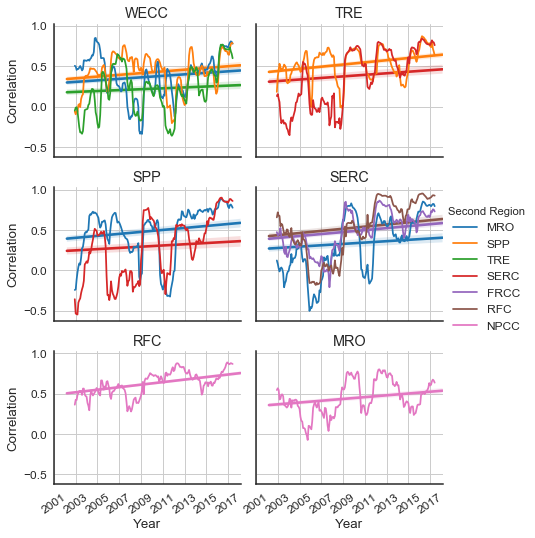

In [55]:
order = ['WECC', 'TRE', 'SPP', 'SERC', 'RFC', 'MRO']
g = sns.FacetGrid(corr_tidy.dropna(), col='region1', col_wrap=2, aspect=1.3,
                  hue='region2', palette='tab10', size=2.5)

# regplot for the regression line, but make size of points 0
g.map(sns.regplot, 'datetime_s', 'Correlation', marker='.',
      scatter_kws={'s': 0})

# regplot only does a scatter - add plt.plot for the lines
g.map(plt.plot, 'datetime_s', 'Correlation')


# Create custom patch lines for the legend - the default dots were small
plot_colors = sns.color_palette('tab10', 7)
legend_patches = [mlines.Line2D([], [], color=c) for c in plot_colors]
legend_order = ['MRO', 'SPP', 'TRE', 'SERC', 'FRCC', 'RFC', 'NPCC']
legend_data = dict(zip(legend_order, legend_patches))
g.add_legend(legend_data=legend_data, title='Second Region')

# Need to do all x-axis work in seconds since epoch, since that's what I'm
# passing through to regplot.
axes = g.axes.flatten()

# Grid lines at the start of each odd year from 2001-17
x_ticks = pd.to_datetime([str(x) for x in range(2001, 2018, 2)]).astype(int)
for ax, title in zip(axes, order):
    ax.set_title(title)
    ax.set_xticks(x_ticks)

# Year for the ticklabels
g.set_xticklabels(pd.to_datetime(x_ticks).year, rotation=35)
g.set_xlabels('Year')

path = join(cwd, '..', 'Figures', 'Rolling correlation.pdf')
# plt.savefig(path, bbox_inches='tight')